# **COMPONENT 3 - RNN next note for backing track**

This is part 3 of the three component pipeline titled 'Recurrent Rhapsody'. Here, we train the RNN model to predict a MIDI sequence when fed a priming sequence.

### Loading the required libraries

Here, we specify some paths and download the relevant packages needed to train the model.

In [ ]:
import os
import shutil
import glob
import numpy as np 
import pandas as pd
!pip install pretty_midi
import pretty_midi
!pip install pypianoroll
import pypianoroll
import tables
from music21 import converter, instrument, note, chord, stream
import music21
import librosa
#import librosa.display
import matplotlib.pyplot as plt
from keras.utils import np_utils
import json
import IPython.display
from datetime import datetime
import random

import torch
import torch.nn as nn
from torch.nn import functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from tqdm.notebook import tqdm, trange

import random
import itertools

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.

In [ ]:
root_dir = '/Users/harshitachadha/Desktop/CSCI6364'
data_dir = root_dir + '/Lakh Piano Dataset/LPD-5/lpd_5/lpd_5_cleansed'
music_dataset_lpd_dir = root_dir + '/Music Dataset/midis/lmd_matched'

In [ ]:
!apt-get update -qq && apt-get install -qq libfluidsynth1 fluid-soundfont-gm build-essential libasound2-dev libjack-dev
!pip install -qU pyfluidsynth pretty_midi
!pip install music21
!pip install pypianoroll

zsh:1: command not found: apt-get
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please

### Functions to load relevant files from local machine

The training of the model was done using the local machine and jupyter - the MIDI files and associated metadata is thus not available on a drive and was locally stored. All the relevant files used in this section were sourced from online repositories of the lakh midi dataset, lakh piano dataset, million song dataset or generated during earlier stages of the pipeline.

In [ ]:
RESULTS_PATH = os.path.join(root_dir, 'Lakh Piano Dataset', 'Metadata')

# Utility functions for retrieving paths
def msd_id_to_dirs(msd_id):
    """Given an MSD ID, generate the path prefix.
    E.g. TRABCD12345678 -> A/B/C/TRABCD12345678"""
    return os.path.join(msd_id[2], msd_id[3], msd_id[4], msd_id)


def msd_id_to_h5(msd_id):
    """Given an MSD ID, return the path to the corresponding h5"""
    return os.path.join(RESULTS_PATH, 'lmd_matched_h5',
                        msd_id_to_dirs(msd_id) + '.h5')

# Load the midi npz file from the LMD cleansed folder
def get_midi_npz_path(msd_id, midi_md5):
    return os.path.join(data_dir,
                        msd_id_to_dirs(msd_id), midi_md5 + '.npz')
    
# Load the midi file from the Music Dataset folder
def get_midi_path(msd_id, midi_md5):
    return os.path.join(music_dataset_lpd_dir,
                        msd_id_to_dirs(msd_id), midi_md5 + '.mid')
    
# Open the cleansed ids - cleansed file ids : msd ids
cleansed_ids = pd.read_csv(os.path.join(root_dir, 'Lakh Piano Dataset', 'cleansed_ids.txt'), delimiter = '    ', header = None)
lpd_to_msd_ids = {a:b for a, b in zip(cleansed_ids[0], cleansed_ids[1])}
msd_to_lpd_ids = {a:b for a, b in zip(cleansed_ids[1], cleansed_ids[0])}

# Reading the genre annotations
genre_file_dir = os.path.join(root_dir, 'Lakh Piano Dataset', 'Genre', 'msd_tagtraum_cd1.cls')
ids = []
genres = []
with open(genre_file_dir) as f:
    line = f.readline()
    while line:
        if line[0] != '#':
          split = line.strip().split("\t")
          if len(split) == 2:
            ids.append(split[0])
            genres.append(split[1])
          elif len(split) == 3:
            ids.append(split[0])
            ids.append(split[0])
            genres.append(split[1])
            genres.append(split[2])
        line = f.readline()
genre_df = pd.DataFrame(data={"TrackID": ids, "Genre": genres})

genre_dict = genre_df.groupby('TrackID')['Genre'].apply(lambda x: x.tolist()).to_dict()

<ipython-input-6-96819cab399c>:28: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  cleansed_ids = pd.read_csv(os.path.join(root_dir, 'Lakh Piano Dataset', 'cleansed_ids.txt'), delimiter = '    ', header = None)


In [ ]:
#this information is loaded using metadata available on the lakh pianoroll dataset website
genre_df.head()

,TrackID,Genre
0,TRAAAAK128F9318786,Pop_Rock
1,TRAAAAW128F429D538,Rap
2,TRAAABD128F429CF47,Pop_Rock
3,TRAAAED128E0783FAB,Jazz
4,TRAAAED128E0783FAB,Vocal


In [ ]:
import sqlite3
# Load the processed metadata
#this information is loaded using metadata available on the million song dataset website
cnx = sqlite3.connect(os.path.join(root_dir, 'Lakh Piano Dataset', 'track_metadata.db'))
df = pd.read_sql_query("SELECT * FROM songs", cnx)

In [ ]:
df.head()

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,track_7digitalid,shs_perf,shs_work
0,TRMMMYQ128F932D901,Silent Night,SOQMMHC12AB0180CB8,Monster Ballads X-Mas,ARYZTJS1187B98C555,357ff05d-848a-44cf-b608-cb34b5701ae5,Faster Pussy cat,252.05506,0.649822,0.394032,2003,7032331,-1,0
1,TRMMMKD128F425225D,Tanssi vaan,SOVFVAK12A8C1350D9,Karkuteillä,ARMVN3U1187FB3A1EB,8d7ef530-a6fd-4f8f-b2e2-74aec765e0f9,Karkkiautomaatti,156.55138,0.439604,0.356992,1995,1514808,-1,0
2,TRMMMRX128F93187D9,No One Could Ever,SOGTUKN12AB017F4F1,Butter,ARGEKB01187FB50750,3d403d44-36ce-465c-ad43-ae877e65adc4,Hudson Mohawke,138.97098,0.643681,0.437504,2006,6945353,-1,0
3,TRMMMCH128F425532C,Si Vos Querés,SOBNYVR12A8C13558C,De Culo,ARNWYLR1187B9B2F9C,12be7648-7094-495f-90e6-df4189d68615,Yerba Brava,145.05751,0.448501,0.372349,2003,2168257,-1,0
4,TRMMMWA128F426B589,Tangle Of Aspens,SOHSBXH12A8C13B0DF,Rene Ablaze Presents Winter Sessions,AREQDTE1269FB37231,,Der Mystic,514.29832,0.000000,0.000000,0,2264873,-1,0


Both of the above dfs have a lot of unecessary data so we only keep data of the files that are present in lpd-5 dataset.

In [ ]:
data_path = '/Users/harshitachadha/Desktop/CSCI6364/Lakh Piano Dataset'
cleansed_ids = pd.read_csv(os.path.join(data_path,'cleansed_ids.txt'), delimiter = '    ', header = None)
cleansed_ids.columns =['LPD_ID', 'MSD_ID']
cleansed_ids.head()

<ipython-input-43-81403d34867f>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  cleansed_ids = pd.read_csv(os.path.join(data_path,'cleansed_ids.txt'), delimiter = '    ', header = None)


,LPD_ID,MSD_ID
0,cd3b9c8bb118575bcd712cffdba85fce,TRRNARX128F4264AEB
1,d8392424ea57a0fe6f65447680924d37,TRWMHMP128EF34293F
2,468be2f5dd31a1ba444b8018d8e8c7ad,TRWOLRE128F427D710
3,e6189e77aaca069eeaee516d1dd49995,TRAPFCP128F92D772E
4,cab3e200b884e453f9c035f4f28a2da7,TRBOEFO128F92FC62E


In [ ]:
req_msid = list(cleansed_ids['MSD_ID'])
df = df[df['track_id'].isin(req_msid)]

In [ ]:
df.head()

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,track_7digitalid,shs_perf,shs_work
32,TRMMMQN128F4238509,Raspberry Beret (LP Version),SOGNNYL12A6D4F910B,The Hits/The B-Sides,ARJ3CTF1187B9A1F2E,4c8ead39-b9df-4c56-a27c-51bc049cfd48,Prince & The Revolution,212.06159,0.684808,0.485445,0,1381741,29768,29768
98,TRMMWTG128F4283F07,You Needed Me,SOZTLAR12A8C1368A9,Wind Beneath My Wings,ARVP8NN1187FB3C1D3,80d07b5b-35b1-4d58-a72e-49ac98cba13f,Roger Whittaker,194.53342,0.586746,0.433199,1994,3296492,-1,0
122,TRMMGFX128F92E0CA1,Words - Re-Recording,SOQAWRX12A8C140FB3,Jeannie C. Riley Selected Hits,ARJOEGM1187B9B8F24,79251d77-dd72-46d3-a324-61c27760ce25,Jeannie C. Riley,181.99465,0.505952,0.373235,0,5271769,-1,0
168,TRMMHXK128F42AF4AC,Skase,SOWKZGU12AF72A2B4A,Christos Dantis Best,AROGWRA122988FEE45,,Christos Dantis,220.96934,0.480752,0.417593,0,3476504,-1,0
397,TRMMBOC12903CEB46E,Drumstern (BONUS TRACK),SOLPHZY12AC468ABA8,Sonar Kollektiv - Elektrish Compilation 2,ARK6OTG1187FB3EE00,5a2cda42-e4c1-4bff-824b-bd1b0a2fb6cf,Marcus Worgull,580.41424,0.506928,0.311226,0,8110539,-1,0


In [ ]:
#adding a genre column to df to add additional metadata
df['genre']= df['track_id'].map(genre_dict)

<ipython-input-58-525b55ba8adb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['genre']= df['track_id'].map(genre_dict)


In [ ]:
df.head()

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,track_7digitalid,shs_perf,shs_work,genre
32,TRMMMQN128F4238509,Raspberry Beret (LP Version),SOGNNYL12A6D4F910B,The Hits/The B-Sides,ARJ3CTF1187B9A1F2E,4c8ead39-b9df-4c56-a27c-51bc049cfd48,Prince & The Revolution,212.06159,0.684808,0.485445,0,1381741,29768,29768,NaN
98,TRMMWTG128F4283F07,You Needed Me,SOZTLAR12A8C1368A9,Wind Beneath My Wings,ARVP8NN1187FB3C1D3,80d07b5b-35b1-4d58-a72e-49ac98cba13f,Roger Whittaker,194.53342,0.586746,0.433199,1994,3296492,-1,0,NaN
122,TRMMGFX128F92E0CA1,Words - Re-Recording,SOQAWRX12A8C140FB3,Jeannie C. Riley Selected Hits,ARJOEGM1187B9B8F24,79251d77-dd72-46d3-a324-61c27760ce25,Jeannie C. Riley,181.99465,0.505952,0.373235,0,5271769,-1,0,NaN
168,TRMMHXK128F42AF4AC,Skase,SOWKZGU12AF72A2B4A,Christos Dantis Best,AROGWRA122988FEE45,,Christos Dantis,220.96934,0.480752,0.417593,0,3476504,-1,0,NaN
397,TRMMBOC12903CEB46E,Drumstern (BONUS TRACK),SOLPHZY12AC468ABA8,Sonar Kollektiv - Elektrish Compilation 2,ARK6OTG1187FB3EE00,5a2cda42-e4c1-4bff-824b-bd1b0a2fb6cf,Marcus Worgull,580.41424,0.506928,0.311226,0,8110539,-1,0,NaN


In [ ]:
# Change this into a dictionary of MSD_ID: metadata
lmd_metadata = df.set_index('track_id').T.to_dict('dict')

In [ ]:
#storing this metadata file so that nothing else before this has to be done
import json
with open("master_lpd-5_metadata.json", "w") as outfile:
    json.dump(lmd_metadata, outfile)

In [ ]:
#loading
import json
with open("/Users/harshitachadha/Desktop/CSCI6364/Lakh Piano Dataset/Metadata/master_lpd-5_metadata.json") as json_file:
    lmd_metadata = json.load(json_file)

### Exploring the data

Exploring the metadata files to narrow down the size of the dataset to maintain generated song coherency.

In [ ]:
# Get the most common artists
from collections import Counter
artist_counter = Counter(v['artist_name'] for v in lmd_metadata.values())
artist_counter.most_common(n = 20)

[('Panpipes', 77),
 ('Green Day', 39),
 ('Mariah Carey', 38),
 ('Mariano Yanani', 34),
 ('The Corrs', 33),
 ('Floyd Cramer', 33),
 ('Abba', 30),
 ('Michael Jackson', 30),
 ('Electric Light Orchestra', 30),
 ('Madonna', 30),
 ('The Cranberries', 29),
 ('Britney Spears', 28),
 ('Richard Clayderman', 28),
 ('Backstreet Boys', 27),
 ('Ace Cannon', 27),
 ('U2', 27),
 ('Spice Girls', 27),
 ('The Cure', 27),
 ('Céline Dion', 26),
 ('Muse', 26)]

In [ ]:
# Get all song MSD IDs where artist is Queen
filtered_msd_ids = {k:v['title'] for k, v in lmd_metadata.items() if v['artist_name'] in ['Abba','Queen','Green Day','Muse','The Cranberries','Radiohead','My Chemical Romance']}
filtered_msd_ids

{'TRMGOJV128F92EFECC': 'Kisses Of Fire',
 'TRMCNML128EF35191B': 'Saving Grace',
 'TRMAFWC128F423E58F': 'To The End (Album Version)',
 'TRMNQZI128F42B58E8': 'Bliss',
 'TRMVHUY128E0791209': 'Sunday',
 'TRWWMWX128F428686C': 'All Dead All Dead (1993 Digital Remaster)',
 'TRWWHPU128E078585C': "Bab's Uvula Who? (Album Version)",
 'TRWBDAW128F426BD99': 'I Am The City',
 'TRWQNLI128F146D78F': 'The Ghost Of You (Live Version) (AOL Sessions)',
 'TRWQXAK128E0780DD4': 'A Kind Of Magic',
 'TRWACRO128F932A063': 'One Of My Lies (Album version)',
 'TRWAVSM128F428711F': 'Heaven For Everyone (Album Version)',
 'TRWPXOX128F93465C6': 'Starlight',
 'TRWSHFZ128F92E202D': 'Sober [Saint US Mix]',
 'TRGMFYB128F429823D': 'Tie Your Mother Down',
 'TRGBWJL128F9332B52': 'Zombie',
 'TRGFVGL128E078F2D9': 'Honey_ Honey',
 'TRGIIJG128F429500E': 'Heaven Help Us [B-Side]',
 'TRGTWMB128E078F2E5': 'Dancing Queen',
 'TRGVSMR128F42B58E7': 'New Born',
 'TRGOZZZ128E0785872': 'King For A Day (Album Version)',
 'TRGKMZE128F9310

In [ ]:
len(filtered_msd_ids)

177

### Working with the MIDI files

Accessing and loading the MIDI files as tensors to be fed into model.

In [ ]:
# Loop that reads each song in train_ids, parses the PIANO notes and saves the string representation of the note in notes
notes = []

i = 0
for msd_file_name in filtered_msd_ids:
  lpd_file_name = msd_to_lpd_ids[msd_file_name]

  # Get the NPZ path
  npz_path = get_midi_npz_path(msd_file_name, lpd_file_name)

  multitrack = pypianoroll.load(npz_path)
  pm = pypianoroll.to_pretty_midi(multitrack)
  new_midi_path = npz_path[:-4] + '.mid'
  pypianoroll.write(new_midi_path, multitrack)
  # Get the MIDI path (should already be generated)
  new_midi_path = npz_path[:-4] + '.mid'
  midi = converter.parse(new_midi_path)

  s2 = instrument.partitionByInstrument(midi)
  piano_part = None
  # Filter for  only the piano part
  instr = instrument.Piano
  for part in s2:
    if isinstance(part.getInstrument(), instr):
      piano_part = part

  notes_song = []
  if piano_part: # Some songs somehow have no piano parts
    for element in piano_part:
      if isinstance(element, note.Note):
        # Return the pitch of the single note
          notes_song.append(str(element.pitch))
      elif isinstance(element, chord.Chord):
        # Returns the normal order of a Chord represented in a list of integers
          notes_song.append('.'.join(str(n) for n in element.normalOrder))

  notes.append(notes_song)
  i+=1
  print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177


In [ ]:
# Random Train test split 
random.seed(42)
test_ids = random.choices(list(range(177)), k = 50)
train_ids = [e for e in range(177) if e not in test_ids]

notes_train = [notes[i] for i in train_ids]
notes_test = [notes[i] for i in test_ids]

with open(os.path.join(root_dir, 'Lakh Piano Dataset', 'notes_initial_train.json'), 'w') as outfile:
  json.dump(notes_train, outfile)

with open(os.path.join(root_dir, 'Lakh Piano Dataset', 'notes_initial_test.json'), 'w') as outfile:
  json.dump(notes_test, outfile)
     

In [ ]:
# Loading the files
with open(os.path.join(root_dir, 'Lakh Piano Dataset', 'notes_initial_train.json'), 'r') as outfile:
  notes_train = json.load(outfile)

with open(os.path.join(root_dir, 'Lakh Piano Dataset', 'notes_initial_test.json'), 'r') as outfile:
  notes_test = json.load(outfile)

In [ ]:

# Prepare input and output sequences

def prepare_sequences(notes, note_to_int = None, sequence_length = 32):
  network_input = []
  network_output = []

  if not note_to_int:
    # Set of note/chords (collapse into list)
    pitch_names = sorted(set(itertools.chain(*notes)))
    # create a dictionary to map pitches to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitch_names))

  # Loop through all songs
  for song in notes:
    # Check for the end
    i = 0
    while i + sequence_length < len(song):
      # seq_len notes for the input seq
      sequence_in = song[i: i + sequence_length]
      # Next note to predict
      sequence_out = song[i+sequence_length]
      # Return the int representation of the note - *(If note not found)
      network_input.append([note_to_int.get(char, 0) for char in sequence_in])
      network_output.append(note_to_int.get(sequence_out, 0))
      i += sequence_length

  n_patterns = len(network_input)

  # Reshape for LSTM input
  network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
  # Normalize input (?? - CHECK LATER - this assumes the alphabetical order of the notes carries semantic meaning?)
  #network_input = network_input / len(pitch_names)
  #network_output = np_utils.to_categorical(network_output)

  return network_input, network_output, note_to_int

train_input, train_output, note_to_int = prepare_sequences(notes_train, sequence_length = 64)
#test_input, test_output, _ = prepare_sequences(notes_test, note_to_int = note_to_int, sequence_length = 64)

In [ ]:
int_to_note = {number:note for note, number in note_to_int.items()}

### The model

Defining the model and some helper functions.


In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Take a random observation from the network input, return (input, target), each shifted by 1
# NOT NEEDED ANYMORE - each epoch just using entire dataset
def random_training_set(network_input):    
    chunk = network_input[random.randint(0, network_input.shape[0] - 1), : , :]
    input = torch.tensor(chunk[:-1], dtype = torch.long).squeeze()
    target = torch.tensor(chunk[1:], dtype = torch.long).squeeze()
    return input, target


def grad_clipping(net, theta):  
    """Clip the gradient."""
    params = [p for p in net.parameters() if p.requires_grad]

    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm
     

In [ ]:
class GenerationRNN(nn.Module):
  # input_size: number of possible pitches
  # hidden_size: embedding size of each pitch
  # output_size: number of possible pitches (probability distribution)
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(GenerationRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size * n_layers, output_size)
    
    def forward(self, input, hidden):
        # Creates embedding of the input texts
        #print('initial input', input.size())
        input = self.embedding(input.view(1, -1))
        #print('input after embedding', input.size())
        output, hidden = self.gru(input, hidden)
        #print('output after gru', output.size())
        #print('hidden after gru', hidden.size())
        output = self.decoder(hidden.view(1, -1))
        #print('output after decoder', output.size())
        return output, hidden

    def init_hidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_size).to(device)
     

In [ ]:
# Single training step for ONE sequence
def train_sequence(input, target, model, optimizer, criterion):
    # Initialize hidden state, zero the gradients of model 
    hidden = model.init_hidden()
    model.zero_grad()
    loss = 0
    # For each character in our chunk (except last), compute the hidden and ouput
    # Using each output, compute the loss with the corresponding target 
    for i in range(len(input)):
        output, hidden = model(input[i], hidden)
        loss += criterion(output, target[i].unsqueeze(0))
    
    # Backpropagate, clip gradient and optimize
    loss.backward()
    grad_clipping(model, 1)
    optimizer.step()

    # Return average loss for the input sequence
    return loss.data.item() / len(input)

def test_sequence(input, target, model, criterion):
    # Initialize hidden state, zero the gradients of model 
    hidden = model.init_hidden()
    model.zero_grad()
    loss = 0
    # For each character in our chunk (except last), compute the hidden and ouput
    # Using each output, compute the loss with the corresponding target 
    for i in range(len(input)):
        output, hidden = model(input[i], hidden)
        loss += criterion(output, target[i].unsqueeze(0))

    # Return average loss for the input sequence
    return loss.data.item() / len(input)

In [ ]:
# Overall training loop
def training_loop(model, optimizer, scheduler, criterion, train_input, test_input):

  train_losses = []
  test_losses = []

  for epoch in range(1, n_epochs + 1):
    running_loss = 0
    model.train()

    # Training - sample 2000
    sampled_train_ids = random.choices(range(train_input.shape[0]), k = 2000)
    print(scheduler.get_last_lr())
    for i in range(train_input.shape[0]):
      sequence = train_input[i, : , :]
      input = torch.tensor(sequence[:-1], dtype = torch.long).squeeze().to(device)
      target = torch.tensor(sequence[1:], dtype = torch.long).squeeze().to(device)
      loss = train_sequence(input, target, model, optimizer, criterion)
      running_loss += loss

    train_epoch_loss = running_loss / 2000
    train_losses.append(train_epoch_loss)
    scheduler.step()

    running_loss = 0
    test_epoch_loss = 0

    print('Epoch {}, Train Loss: {}, Test Loss: {}, Time: {}'.format(epoch, train_epoch_loss, test_epoch_loss, datetime.now()))

  return train_losses, test_losses

In [ ]:
n_pitches = len(note_to_int)
hidden_size = 96
n_layers = 2
n_epochs = 40
lr = 0.002
lr_lambda = 0.99

model = GenerationRNN(input_size = n_pitches, hidden_size = hidden_size, output_size = n_pitches, n_layers = n_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: lr_lambda ** epoch)
criterion = nn.CrossEntropyLoss()
train_losses, test_losses = training_loop(model, optimizer, scheduler, criterion, train_input, train_input)

[0.002]
Epoch 1, Train Loss: 0.9472913717845122, Test Loss: 0, Time: 2023-04-29 20:04:35.066507
[0.00198]
Epoch 2, Train Loss: 0.6973250942381604, Test Loss: 0, Time: 2023-04-29 20:05:08.612391
[0.0019602]
Epoch 3, Train Loss: 0.5554035420569164, Test Loss: 0, Time: 2023-04-29 20:05:56.332752
[0.0019405980000000002]
Epoch 4, Train Loss: 0.4574654033865249, Test Loss: 0, Time: 2023-04-29 20:06:39.062898
[0.0019211920199999999]
Epoch 5, Train Loss: 0.3817751448267978, Test Loss: 0, Time: 2023-04-29 20:07:21.792588
[0.0019019800997999998]
Epoch 6, Train Loss: 0.3280367001787064, Test Loss: 0, Time: 2023-04-29 20:07:59.775261
[0.001882960298802]
Epoch 7, Train Loss: 0.28845815026712796, Test Loss: 0, Time: 2023-04-29 20:08:35.938116
[0.0018641306958139799]
Epoch 8, Train Loss: 0.25868802618956765, Test Loss: 0, Time: 2023-04-29 20:09:11.603963
[0.0018454893888558402]
Epoch 9, Train Loss: 0.2291124823794123, Test Loss: 0, Time: 2023-04-29 20:09:46.326587
[0.0018270344949672817]
Epoch 10, Tr

In [ ]:
# Save Model
model_name = 'Comp3_RNN_29APR'
save_path = os.path.join(root_dir, 'Saved Models', model_name)
torch.save(model.state_dict(), save_path)

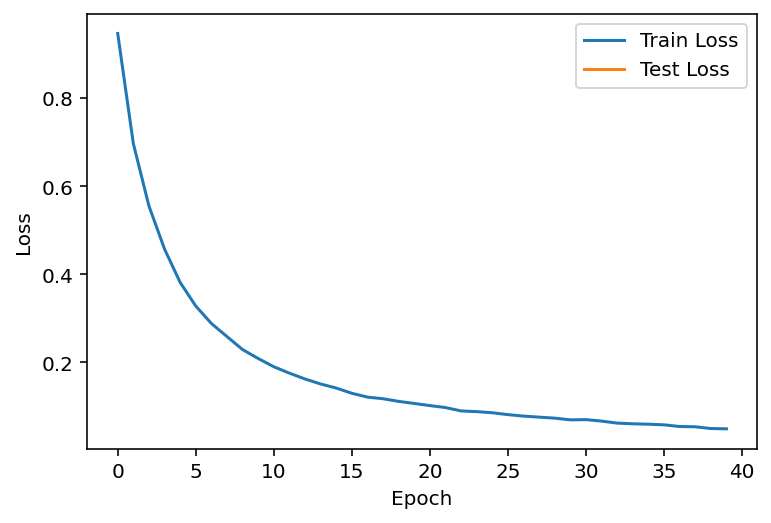

In [ ]:
# Plot the losses over epochs
plt.figure()
plt.plot(train_losses, label = 'Train Loss')
plt.plot(test_losses, label = 'Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Evaluating the model

Creating functions to generate new music

In [ ]:
def evaluate(net, prime_seq, predict_len):
    '''
    Arguments:
    prime_seq - priming sequence (converted t)
    predict_len - number of notes to predict for after prime sequence
    '''
    hidden = net.init_hidden()

    predicted = prime_seq.copy()
    prime_seq = torch.tensor(prime_seq, dtype = torch.long).to(device)


    # "Building up" the hidden state using the prime sequence
    for p in range(len(prime_seq) - 1):
        input = prime_seq[p]
        _, hidden = net(input, hidden)
    
    # Last character of prime sequence
    input = prime_seq[-1]
    
    # For every index to predict
    for p in range(predict_len):

        # Pass the inputs to the model - output has dimension n_pitches - scores for each of the possible characters
        output, hidden = net(input, hidden)

        # Pick the character with the highest probability 
        predicted_id = torch.argmax(torch.softmax(output, dim = 1))

        # Add predicted index to the list and use as next input
        predicted.append(predicted_id.item()) 
        input = predicted_id

    return predicted

In [ ]:
generated_seq = evaluate(model, [100, 101, 102, 101, 100], predict_len = 100)
print(generated_seq)

[100, 101, 102, 101, 100, 311, 82, 82, 311, 72, 72, 248, 163, 219, 63, 201, 219, 63, 311, 312, 249, 311, 299, 262, 268, 30, 82, 177, 102, 294, 279, 296, 235, 244, 265, 89, 63, 294, 98, 29, 294, 146, 225, 228, 295, 35, 248, 228, 219, 225, 293, 225, 293, 246, 244, 98, 248, 246, 279, 100, 244, 298, 279, 244, 298, 244, 298, 228, 246, 228, 246, 228, 246, 246, 228, 293, 219, 228, 246, 228, 246, 100, 246, 228, 228, 246, 100, 279, 100, 100, 279, 228, 228, 228, 228, 37, 37, 37, 37, 219, 37, 302, 151, 24, 247]
[100, 101, 102, 101, 100, 311, 248, 82, 247, 299, 63, 283, 290, 299, 283, 248, 300, 299, 248, 248, 248, 248, 248, 300, 248, 250, 248, 248, 248, 248, 248, 248, 248, 248, 248, 267, 247, 248, 98, 248, 98, 244, 299, 181, 193, 294, 278, 248, 246, 148, 280, 255, 100, 244, 100, 100, 100, 298, 100, 228, 228, 228, 228, 228, 228, 228, 278, 74, 190, 190, 190, 79, 101, 244, 259, 164, 280, 98, 100, 244, 100, 100, 100, 228, 100, 100, 228, 228, 228, 228, 228, 40, 190, 79, 79, 100, 247, 190, 247, 90, 228,

In [ ]:
# Convert the generated ints into notes
generated_seq = [int_to_note[e] for e in generated_seq]
generated_seq_multinomial = [int_to_note[e] for e in generated_seq_multinomial]

In [ ]:
def create_midi(prediction_output):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)

    return midi_stream

In [ ]:
generated_path = os.path.join(root_dir, 'Generated MIDIs', '29apr_comp3_single.mid')
generated_stream = create_midi(generated_seq_multinomial) #or generated_seq
generated_stream.write('midi', fp=generated_path)

'/Users/harshitachadha/Desktop/CSCI6364/Generated MIDIs/29apr_comp3_single.mid'